<a href="https://colab.research.google.com/github/agarr3/vajra-new/blob/main/AE_HYBRID_LSTM_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from tqdm import tqdm_notebook as tqdm
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import matplotlib.pyplot as plt
import torch
# Neural networks can be constructed using the torch.nn package.
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import Dataset
import torchvision
import torchvision.transforms as transforms

import IPython.display as ipd

import random

In [24]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
#settings
batch_size = 64
validation_split = .3
shuffle_dataset = True
random_seed= 42
reduction_loss = "mean"
if reduction_loss == "mean":
  criterion = nn.MSELoss(reduction="mean")
elif reduction_loss == "sum":
  criterion = nn.MSELoss(reduction="sum")
n_epochs = 30
print_every = 1

BASE_PATH = "/content/gdrive/My Drive/vajra/AE_HYBRID_LSTM_V1/"

input_bins = 48
seq_len=200
AE_encoded_dim = 64

print(device)

cuda:0


In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [4]:
DATA_BASE_PATH = "/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/"
DATA_SONG_DIR = "48Bins"
DATA_IMG_DIR = "48Bins"

files = []
exclusion = ["098567.npy","098569.npy", '098565.npy']
for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_numpy"):
  for file in fileList:
    if(file not in exclusion):
      files.append([file,file, "Western_numpy"])
    else:
      print(file)

random.seed(1234)
files = random.sample(files, 2008)

for r,d, fileList in os.walk("/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Indian_numpy"):
  for file in fileList:
    if(True):
      files.append([file,file, "Indian_numpy"])
    else:
      print(file)

dataDF = pd.DataFrame(files, columns=['Images','songs','labels'])
dataDF.head()

,Images,songs,labels
0,039357.npy,039357.npy,Western_numpy
1,107591.npy,107591.npy,Western_numpy
2,143217.npy,143217.npy,Western_numpy
3,140623.npy,140623.npy,Western_numpy
4,147059.npy,147059.npy,Western_numpy


In [5]:
dataDF.groupby("labels").count()

,Images,songs
labels,,
Indian_numpy,2008,2008
Western_numpy,2008,2008


/content/gdrive/My Drive/vajra/songs-vajra-data/MEL/48Bins/Western_numpy/122646.npy
80.0


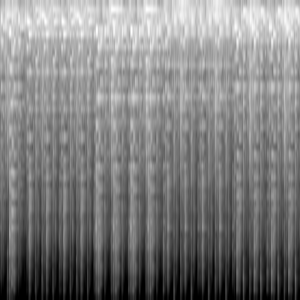

In [6]:
test_idx = random. randint(0,1000)
test_img_path = os.path.join(DATA_BASE_PATH, DATA_IMG_DIR, dataDF.loc[test_idx, 'labels'], dataDF.loc[test_idx, 'Images'])
print(test_img_path)

numpy_arr = np.load(test_img_path)

array = numpy_arr*-1
print(array.max())
array *= (255.0/array.max())
array = 255 - array

test_image = Image.fromarray(array)
test_image = test_image.convert('L')
test_image = test_image.resize((300,300))
test_image



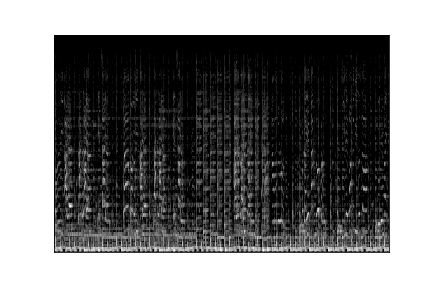

In [7]:
test_img_path = '/content/gdrive/My Drive/Kaggle/GTZAN/Data/images_original/reggae/reggae00016.png'
test_image = Image.open(test_img_path)
test_image = test_image.convert('RGB').convert('L')
test_image

In [8]:
lb = LabelEncoder()
dataDF['encoded_labels'] = lb.fit_transform(dataDF['labels'])
dataDF.head()

,Images,songs,labels,encoded_labels
0,039357.npy,039357.npy,Western_numpy,1
1,107591.npy,107591.npy,Western_numpy,1
2,143217.npy,143217.npy,Western_numpy,1
3,140623.npy,140623.npy,Western_numpy,1
4,147059.npy,147059.npy,Western_numpy,1


In [9]:
classes = ('Indian_numpy', 'Western_numpy')
dataDF.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,2008,2008
Western_numpy,1,2008,2008


In [10]:
from sklearn.model_selection import train_test_split

dataDF = dataDF.sample(frac=1)
df_train, df_test = train_test_split(dataDF, test_size=validation_split, stratify=dataDF[["labels"]], random_state=9)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

In [11]:
df_train.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,1405,1405
Western_numpy,1,1406,1406


In [12]:
df_test.groupby(by=['labels','encoded_labels']).count()

,,Images,songs
labels,encoded_labels,,
Indian_numpy,0,603,603
Western_numpy,1,602,602


In [13]:
transform_normal = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

transform = transforms.Compose(
    [transforms.ToTensor()])

In [14]:
class MEL_Dataset(Dataset):
    def __init__(self, img_data,img_path,transform=None):
        self.img_path = img_path
        self.transform = transform
        self.img_data = img_data
        
    def __len__(self):
        return len(self.img_data)
    
    def __getitem__(self, index):
        img_name = os.path.join(self.img_path,self.img_data.loc[index, 'labels'],
                                self.img_data.loc[index, 'Images'])
        image = np.load(img_name)
        data = torch.tensor(image[:,:seq_len], dtype=torch.float)
        data = data.permute(1, 0)
        label = torch.tensor(self.img_data.loc[index, 'encoded_labels'])
        return data, label



In [15]:
train_dataset = MEL_Dataset(df_train,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
test_dataset = MEL_Dataset(df_test,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)

In [16]:
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

In [17]:
def mel_display(S_DB):
    S_DB = S_DB.numpy()
    array = S_DB*-1
    array *= (255.0/array.max())
    #array = 255 - array
    array = np.transpose(array, (2, 1, 0))
    return array.squeeze()

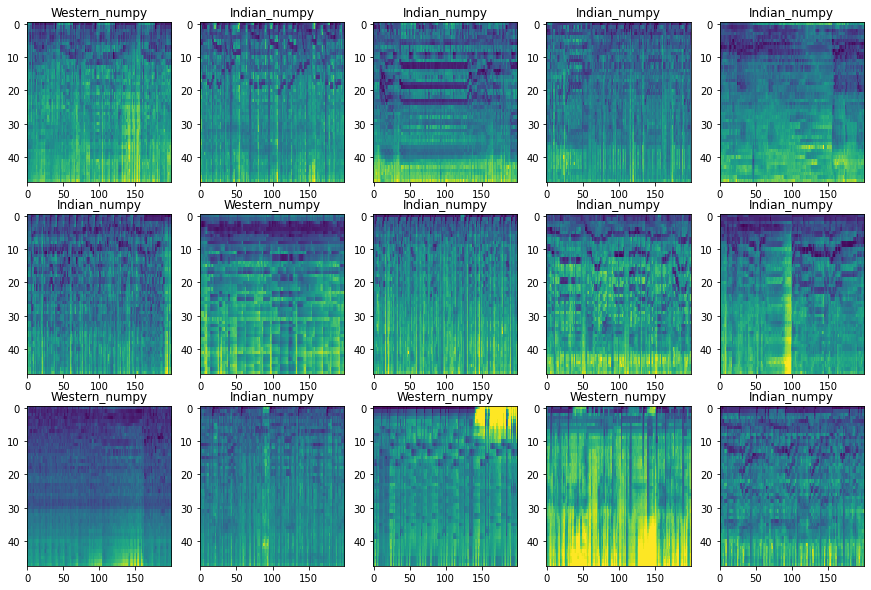

In [18]:
# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

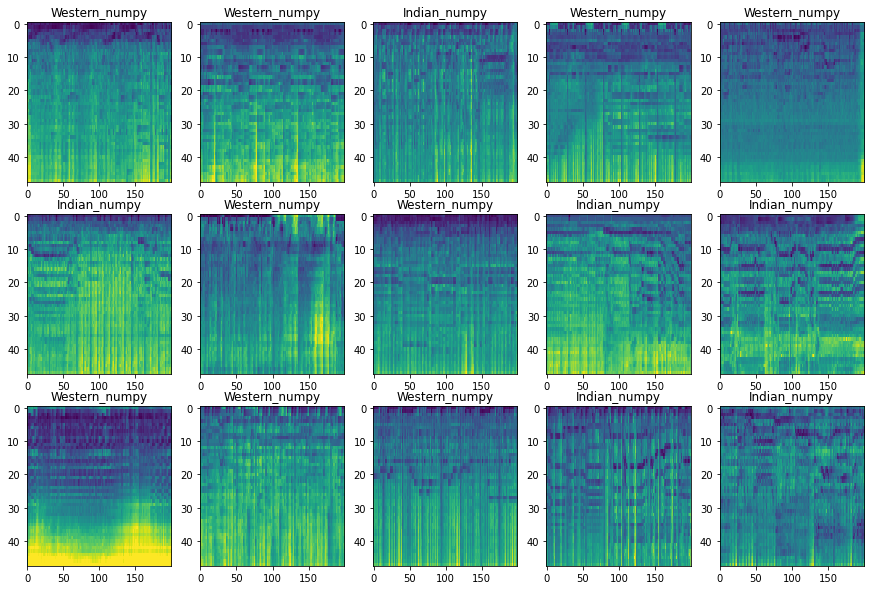

In [19]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        ax.imshow(mel_display(image.unsqueeze(dim=0)), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

In [27]:
class Encoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, kernel_size=[4,3,2], stride=[1,1,1]):
    super(Encoder, self).__init__()
    self.seq_len, self.n_features = seq_len, n_features
    self.embedding_dim, self.hidden_dim = embedding_dim, 2 * embedding_dim


    self.conv = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[0],stride=stride[0], groups=seq_len)
    conv_op_dim = int(((n_features - kernel_size[0])/ stride[0]) + 1)

    self.conv_1 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[1],stride=stride[1], groups=seq_len)
    conv_op_dim1 = int(((conv_op_dim - kernel_size[1])/ stride[1]) + 1)

    self.conv_2 = nn.Conv1d(in_channels=seq_len,out_channels=seq_len,kernel_size=kernel_size[2],stride=stride[2], groups=seq_len)
    conv_op_dim2 = int(((conv_op_dim1 - kernel_size[2])/ stride[2]) + 1)

    self.rnn1 = nn.LSTM(
      input_size=conv_op_dim2,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=self.hidden_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
  def forward(self, x):
    x = self.conv(x)
    x = self.conv_1(x)
    x = self.conv_2(x)
    lstm_l1_op, (_, _) = self.rnn1(x)
    lstm_l2_op, (hidden_n, _) = self.rnn2(lstm_l1_op)
    return lstm_l2_op, lstm_l1_op

class Decoder(torch.nn.Module):
  def __init__(self, seq_len, embedding_dim=64, n_features=26):
    super(Decoder, self).__init__()
    self.seq_len, self.embedding_dim = seq_len, embedding_dim
    self.hidden_dim, self.n_features = 2 * embedding_dim, n_features
    self.rnn1 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=embedding_dim,
      num_layers=1,
      batch_first=True
    )
    self.rnn2 = nn.LSTM(
      input_size=embedding_dim,
      hidden_size=self.hidden_dim,
      num_layers=1,
      batch_first=True
    )
    self.output_layer = nn.Linear(self.hidden_dim * self.seq_len, n_features * self.seq_len)
  def forward(self, x):
    x, (hidden_n, cell_n) = self.rnn1(x)
    x, (hidden_n, cell_n) = self.rnn2(x)
    x = x.contiguous()
    x = x.view(x.shape[0], -1)
    x = self.output_layer(x)
    return x.reshape(x.shape[0],self.seq_len, self.n_features)

class RecurrentAutoencoder(torch.nn.Module):
  def __init__(self, seq_len, n_features, embedding_dim=64, device='cpu'):
    super(RecurrentAutoencoder, self).__init__()
    self.encoder = Encoder(seq_len, n_features, embedding_dim).to(device)
    self.decoder = Decoder(seq_len, embedding_dim, n_features).to(device)
  def forward(self, x):
    x, l1_op = self.encoder(x)
    x = self.decoder(x)
    return x

net = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
net.to(device)


RecurrentAutoencoder(
  (encoder): Encoder(
    (conv): Conv1d(200, 200, kernel_size=(4,), stride=(1,), groups=200)
    (conv_1): Conv1d(200, 200, kernel_size=(3,), stride=(1,), groups=200)
    (conv_2): Conv1d(200, 200, kernel_size=(2,), stride=(1,), groups=200)
    (rnn1): LSTM(42, 128, batch_first=True)
    (rnn2): LSTM(128, 64, batch_first=True)
  )
  (decoder): Decoder(
    (rnn1): LSTM(64, 64, batch_first=True)
    (rnn2): LSTM(64, 128, batch_first=True)
    (output_layer): Linear(in_features=25600, out_features=9600, bias=True)
  )
)

In [28]:
optimizer = torch.optim.Adam(net.parameters(), lr=0.001)

In [22]:
import matplotlib.pyplot as plt
import numpy as np

def visualize(train_loss_graph, test_loss_graph):
  x = range(len(train_loss_graph))
      
  # plot lines
  plt.plot(x, train_loss_graph, label = "Training Loss")
  plt.plot(x, test_loss_graph, label = "Test Loss")
  
  plt.legend()
  plt.show()


[1,     1] loss: 1388.359
[1,     2] loss: 1422.086
[1,     3] loss: 1200.142
[1,     4] loss: 1053.758
[1,     5] loss: 969.905
[1,     6] loss: 808.137
[1,     7] loss: 652.243
[1,     8] loss: 456.851
[1,     9] loss: 197.908
[1,    10] loss: 599.673
[1,    11] loss: 335.476
[1,    12] loss: 134.515
[1,    13] loss: 119.925
[1,    14] loss: 169.531
[1,    15] loss: 201.979
[1,    16] loss: 229.241
[1,    17] loss: 239.318
[1,    18] loss: 225.992
[1,    19] loss: 169.051
[1,    20] loss: 163.076
[1,    21] loss: 160.151
[1,    22] loss: 133.315
[1,    23] loss: 123.110
[1,    24] loss: 143.962
[1,    25] loss: 144.186
[1,    26] loss: 196.632
[1,    27] loss: 185.517
[1,    28] loss: 161.331
[1,    29] loss: 118.428
[1,    30] loss: 139.498
[1,    31] loss: 114.508
[1,    32] loss: 103.881
[1,    33] loss: 141.836
[1,    34] loss: 100.175
[1,    35] loss: 104.214
[1,    36] loss: 150.729
[1,    37] loss: 141.599
[1,    38] loss: 131.411
[1,    39] loss: 134.116
[1,    40] loss: 125.

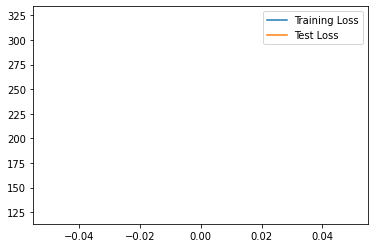

[2,     1] loss: 118.558
[2,     2] loss: 125.504
[2,     3] loss: 103.678
[2,     4] loss: 98.856
[2,     5] loss: 96.241
[2,     6] loss: 94.357
[2,     7] loss: 104.025
[2,     8] loss: 131.719
[2,     9] loss: 130.116
[2,    10] loss: 133.295
[2,    11] loss: 95.553
[2,    12] loss: 97.102
[2,    13] loss: 102.463
[2,    14] loss: 127.396
[2,    15] loss: 97.060
[2,    16] loss: 118.140
[2,    17] loss: 113.037
[2,    18] loss: 113.276
[2,    19] loss: 106.138
[2,    20] loss: 107.154
[2,    21] loss: 117.510
[2,    22] loss: 108.186
[2,    23] loss: 97.343
[2,    24] loss: 118.130
[2,    25] loss: 106.535
[2,    26] loss: 116.159
[2,    27] loss: 122.340
[2,    28] loss: 122.629
[2,    29] loss: 91.580
[2,    30] loss: 123.495
[2,    31] loss: 102.801
[2,    32] loss: 98.695
[2,    33] loss: 117.349
[2,    34] loss: 90.761
[2,    35] loss: 91.665
[2,    36] loss: 119.613
[2,    37] loss: 114.847
[2,    38] loss: 114.179
[2,    39] loss: 113.599
[2,    40] loss: 108.640
[2,    41] 

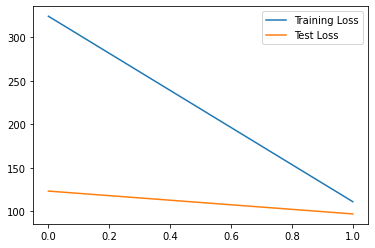

[3,     1] loss: 93.071
[3,     2] loss: 94.890
[3,     3] loss: 80.407
[3,     4] loss: 77.998
[3,     5] loss: 73.016
[3,     6] loss: 74.908
[3,     7] loss: 82.651
[3,     8] loss: 82.487
[3,     9] loss: 94.943
[3,    10] loss: 76.941
[3,    11] loss: 71.770
[3,    12] loss: 72.815
[3,    13] loss: 73.089
[3,    14] loss: 83.768
[3,    15] loss: 69.460
[3,    16] loss: 78.883
[3,    17] loss: 75.763
[3,    18] loss: 75.520
[3,    19] loss: 69.179
[3,    20] loss: 77.719
[3,    21] loss: 72.431
[3,    22] loss: 69.759
[3,    23] loss: 70.099
[3,    24] loss: 76.466
[3,    25] loss: 70.652
[3,    26] loss: 76.989
[3,    27] loss: 76.082
[3,    28] loss: 78.694
[3,    29] loss: 69.745
[3,    30] loss: 77.214
[3,    31] loss: 74.333
[3,    32] loss: 69.961
[3,    33] loss: 73.725
[3,    34] loss: 70.808
[3,    35] loss: 71.452
[3,    36] loss: 72.340
[3,    37] loss: 73.940
[3,    38] loss: 84.143
[3,    39] loss: 74.322
[3,    40] loss: 72.798
[3,    41] loss: 67.584
[3,    42] loss:

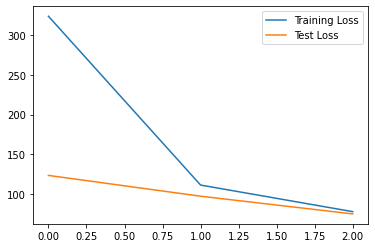

[4,     1] loss: 67.575
[4,     2] loss: 68.526
[4,     3] loss: 64.374
[4,     4] loss: 65.164
[4,     5] loss: 62.977
[4,     6] loss: 64.338
[4,     7] loss: 74.994
[4,     8] loss: 71.584
[4,     9] loss: 85.694
[4,    10] loss: 71.483
[4,    11] loss: 66.992
[4,    12] loss: 69.637
[4,    13] loss: 70.801
[4,    14] loss: 78.617
[4,    15] loss: 66.289
[4,    16] loss: 75.900
[4,    17] loss: 72.607
[4,    18] loss: 71.090
[4,    19] loss: 67.822
[4,    20] loss: 72.066
[4,    21] loss: 70.949
[4,    22] loss: 67.232
[4,    23] loss: 69.593
[4,    24] loss: 74.714
[4,    25] loss: 69.954
[4,    26] loss: 73.465
[4,    27] loss: 72.355
[4,    28] loss: 77.850
[4,    29] loss: 68.505
[4,    30] loss: 75.968
[4,    31] loss: 72.849
[4,    32] loss: 68.932
[4,    33] loss: 72.387
[4,    34] loss: 69.094
[4,    35] loss: 70.399
[4,    36] loss: 70.958
[4,    37] loss: 73.497
[4,    38] loss: 82.630
[4,    39] loss: 73.768
[4,    40] loss: 71.375
[4,    41] loss: 67.028
[4,    42] loss:

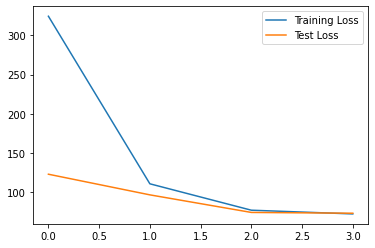

[5,     1] loss: 66.852
[5,     2] loss: 67.857
[5,     3] loss: 63.633
[5,     4] loss: 64.778
[5,     5] loss: 62.461
[5,     6] loss: 63.833
[5,     7] loss: 74.209
[5,     8] loss: 71.120
[5,     9] loss: 84.768
[5,    10] loss: 70.900
[5,    11] loss: 66.626
[5,    12] loss: 69.348
[5,    13] loss: 70.331
[5,    14] loss: 77.619
[5,    15] loss: 65.976
[5,    16] loss: 75.710
[5,    17] loss: 72.102
[5,    18] loss: 70.835
[5,    19] loss: 67.433
[5,    20] loss: 71.527
[5,    21] loss: 70.289
[5,    22] loss: 66.705
[5,    23] loss: 69.181
[5,    24] loss: 74.010
[5,    25] loss: 69.320
[5,    26] loss: 72.879
[5,    27] loss: 71.665
[5,    28] loss: 76.926
[5,    29] loss: 68.325
[5,    30] loss: 75.404
[5,    31] loss: 72.494
[5,    32] loss: 69.045
[5,    33] loss: 71.816
[5,    34] loss: 69.328
[5,    35] loss: 70.142
[5,    36] loss: 70.743
[5,    37] loss: 72.914
[5,    38] loss: 82.699
[5,    39] loss: 73.187
[5,    40] loss: 71.278
[5,    41] loss: 66.655
[5,    42] loss:

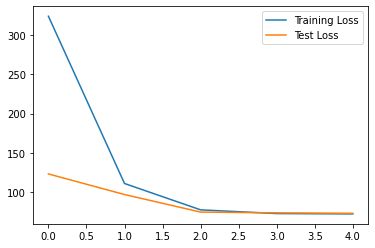

[6,     1] loss: 66.485
[6,     2] loss: 67.562
[6,     3] loss: 63.146
[6,     4] loss: 64.562
[6,     5] loss: 62.157
[6,     6] loss: 63.560
[6,     7] loss: 73.569
[6,     8] loss: 70.895
[6,     9] loss: 84.004
[6,    10] loss: 70.555
[6,    11] loss: 66.185
[6,    12] loss: 69.244
[6,    13] loss: 69.825
[6,    14] loss: 76.978
[6,    15] loss: 65.408
[6,    16] loss: 75.588
[6,    17] loss: 71.396
[6,    18] loss: 70.639
[6,    19] loss: 66.996
[6,    20] loss: 71.197
[6,    21] loss: 69.349
[6,    22] loss: 66.229
[6,    23] loss: 68.725
[6,    24] loss: 73.582
[6,    25] loss: 68.675
[6,    26] loss: 72.587
[6,    27] loss: 70.918
[6,    28] loss: 76.370
[6,    29] loss: 67.637
[6,    30] loss: 74.895
[6,    31] loss: 71.802
[6,    32] loss: 68.679
[6,    33] loss: 70.889
[6,    34] loss: 68.595
[6,    35] loss: 69.798
[6,    36] loss: 69.927
[6,    37] loss: 72.163
[6,    38] loss: 82.073
[6,    39] loss: 72.511
[6,    40] loss: 70.507
[6,    41] loss: 66.202
[6,    42] loss:

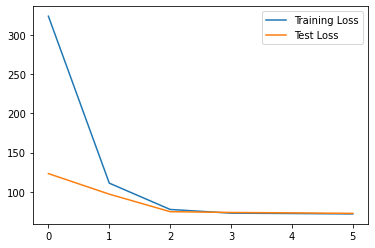

[7,     1] loss: 66.084
[7,     2] loss: 66.673
[7,     3] loss: 62.689
[7,     4] loss: 64.161
[7,     5] loss: 61.949
[7,     6] loss: 63.107
[7,     7] loss: 72.828
[7,     8] loss: 70.499
[7,     9] loss: 83.135
[7,    10] loss: 69.760
[7,    11] loss: 65.780
[7,    12] loss: 68.509
[7,    13] loss: 69.295
[7,    14] loss: 76.175
[7,    15] loss: 64.846
[7,    16] loss: 74.968
[7,    17] loss: 70.531
[7,    18] loss: 69.910
[7,    19] loss: 66.664
[7,    20] loss: 70.492
[7,    21] loss: 68.180
[7,    22] loss: 65.160
[7,    23] loss: 68.244
[7,    24] loss: 73.015
[7,    25] loss: 68.073
[7,    26] loss: 72.541
[7,    27] loss: 70.467
[7,    28] loss: 75.784
[7,    29] loss: 67.247
[7,    30] loss: 74.182
[7,    31] loss: 71.325
[7,    32] loss: 68.251
[7,    33] loss: 69.935
[7,    34] loss: 67.663
[7,    35] loss: 69.333
[7,    36] loss: 68.899
[7,    37] loss: 71.292
[7,    38] loss: 81.356
[7,    39] loss: 71.811
[7,    40] loss: 69.583
[7,    41] loss: 65.794
[7,    42] loss:

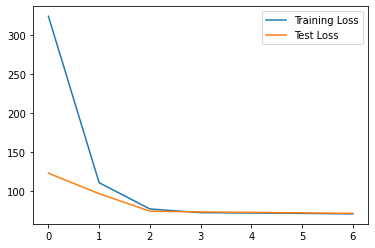

[8,     1] loss: 65.677
[8,     2] loss: 65.559
[8,     3] loss: 62.130
[8,     4] loss: 63.503
[8,     5] loss: 61.715
[8,     6] loss: 62.494
[8,     7] loss: 71.545
[8,     8] loss: 70.148
[8,     9] loss: 81.374
[8,    10] loss: 69.002
[8,    11] loss: 65.166
[8,    12] loss: 67.394
[8,    13] loss: 68.202
[8,    14] loss: 75.178
[8,    15] loss: 64.247
[8,    16] loss: 74.145
[8,    17] loss: 69.404
[8,    18] loss: 69.246
[8,    19] loss: 65.924
[8,    20] loss: 69.540
[8,    21] loss: 66.810
[8,    22] loss: 63.952
[8,    23] loss: 67.035
[8,    24] loss: 71.921
[8,    25] loss: 67.272
[8,    26] loss: 71.106
[8,    27] loss: 69.641
[8,    28] loss: 74.627
[8,    29] loss: 66.890
[8,    30] loss: 73.228
[8,    31] loss: 70.611
[8,    32] loss: 67.880
[8,    33] loss: 68.488
[8,    34] loss: 66.875
[8,    35] loss: 68.304
[8,    36] loss: 68.087
[8,    37] loss: 70.041
[8,    38] loss: 80.056
[8,    39] loss: 71.374
[8,    40] loss: 68.186
[8,    41] loss: 65.496
[8,    42] loss:

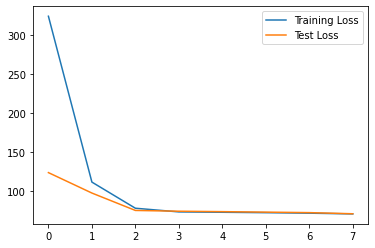

[9,     1] loss: 64.373
[9,     2] loss: 64.452
[9,     3] loss: 61.086
[9,     4] loss: 62.449
[9,     5] loss: 60.715
[9,     6] loss: 61.253
[9,     7] loss: 69.390
[9,     8] loss: 68.866
[9,     9] loss: 77.728
[9,    10] loss: 67.163
[9,    11] loss: 63.364
[9,    12] loss: 64.797
[9,    13] loss: 65.575
[9,    14] loss: 72.963
[9,    15] loss: 62.629
[9,    16] loss: 72.145
[9,    17] loss: 66.867
[9,    18] loss: 67.666
[9,    19] loss: 63.756
[9,    20] loss: 66.696
[9,    21] loss: 64.233
[9,    22] loss: 62.191
[9,    23] loss: 64.123
[9,    24] loss: 69.133
[9,    25] loss: 64.402
[9,    26] loss: 67.947
[9,    27] loss: 67.652
[9,    28] loss: 71.363
[9,    29] loss: 65.482
[9,    30] loss: 71.861
[9,    31] loss: 66.843
[9,    32] loss: 65.272
[9,    33] loss: 64.164
[9,    34] loss: 63.479
[9,    35] loss: 65.639
[9,    36] loss: 66.155
[9,    37] loss: 69.017
[9,    38] loss: 75.395
[9,    39] loss: 68.853
[9,    40] loss: 65.101
[9,    41] loss: 62.603
[9,    42] loss:

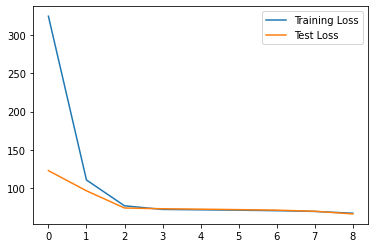

[10,     1] loss: 61.581
[10,     2] loss: 62.003
[10,     3] loss: 59.463
[10,     4] loss: 59.855
[10,     5] loss: 57.700
[10,     6] loss: 58.375
[10,     7] loss: 66.708
[10,     8] loss: 64.204
[10,     9] loss: 72.735
[10,    10] loss: 63.689
[10,    11] loss: 60.922
[10,    12] loss: 60.622
[10,    13] loss: 61.649
[10,    14] loss: 69.136
[10,    15] loss: 58.405
[10,    16] loss: 68.441
[10,    17] loss: 63.018
[10,    18] loss: 65.207
[10,    19] loss: 60.708
[10,    20] loss: 61.903
[10,    21] loss: 61.080
[10,    22] loss: 58.966
[10,    23] loss: 60.789
[10,    24] loss: 65.526
[10,    25] loss: 60.406
[10,    26] loss: 64.517
[10,    27] loss: 62.635
[10,    28] loss: 67.308
[10,    29] loss: 61.199
[10,    30] loss: 68.575
[10,    31] loss: 65.067
[10,    32] loss: 60.519
[10,    33] loss: 59.644
[10,    34] loss: 60.636
[10,    35] loss: 61.714
[10,    36] loss: 62.060
[10,    37] loss: 64.593
[10,    38] loss: 72.720
[10,    39] loss: 64.868
[10,    40] loss: 62.122


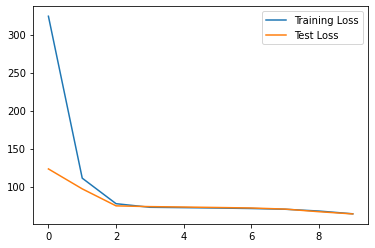

[11,     1] loss: 59.893
[11,     2] loss: 59.393
[11,     3] loss: 57.628
[11,     4] loss: 57.657
[11,     5] loss: 55.300
[11,     6] loss: 56.809
[11,     7] loss: 63.991
[11,     8] loss: 61.657
[11,     9] loss: 67.881
[11,    10] loss: 60.262
[11,    11] loss: 58.952
[11,    12] loss: 57.844
[11,    13] loss: 59.426
[11,    14] loss: 65.970
[11,    15] loss: 56.346
[11,    16] loss: 65.979
[11,    17] loss: 61.175
[11,    18] loss: 63.221
[11,    19] loss: 59.205
[11,    20] loss: 59.122
[11,    21] loss: 58.766
[11,    22] loss: 56.480
[11,    23] loss: 58.704
[11,    24] loss: 63.296
[11,    25] loss: 58.860
[11,    26] loss: 61.385
[11,    27] loss: 60.017
[11,    28] loss: 64.557
[11,    29] loss: 59.716
[11,    30] loss: 67.493
[11,    31] loss: 61.776
[11,    32] loss: 58.645
[11,    33] loss: 57.504
[11,    34] loss: 57.378
[11,    35] loss: 60.683
[11,    36] loss: 59.753
[11,    37] loss: 63.867
[11,    38] loss: 70.199
[11,    39] loss: 63.584
[11,    40] loss: 61.581


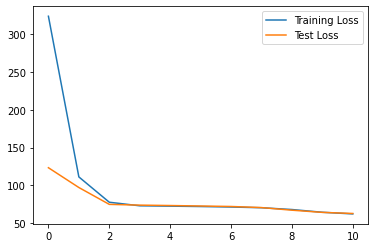

[12,     1] loss: 58.792
[12,     2] loss: 58.753
[12,     3] loss: 57.282
[12,     4] loss: 56.032
[12,     5] loss: 54.619
[12,     6] loss: 55.685
[12,     7] loss: 62.106
[12,     8] loss: 60.024
[12,     9] loss: 65.559
[12,    10] loss: 59.458
[12,    11] loss: 57.903
[12,    12] loss: 56.922
[12,    13] loss: 58.443
[12,    14] loss: 64.748
[12,    15] loss: 55.368
[12,    16] loss: 64.230
[12,    17] loss: 60.430
[12,    18] loss: 61.722
[12,    19] loss: 58.548
[12,    20] loss: 58.287
[12,    21] loss: 57.300
[12,    22] loss: 55.304
[12,    23] loss: 57.432
[12,    24] loss: 61.959
[12,    25] loss: 58.233
[12,    26] loss: 59.822
[12,    27] loss: 58.728
[12,    28] loss: 62.901
[12,    29] loss: 58.885
[12,    30] loss: 65.994
[12,    31] loss: 60.185
[12,    32] loss: 57.329
[12,    33] loss: 55.891
[12,    34] loss: 56.719
[12,    35] loss: 59.182
[12,    36] loss: 59.202
[12,    37] loss: 62.136
[12,    38] loss: 68.399
[12,    39] loss: 62.677
[12,    40] loss: 59.995


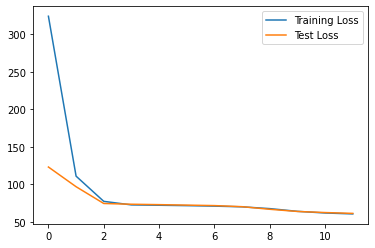

[13,     1] loss: 57.973
[13,     2] loss: 57.467
[13,     3] loss: 55.665
[13,     4] loss: 55.101
[13,     5] loss: 53.340
[13,     6] loss: 55.024
[13,     7] loss: 60.177
[13,     8] loss: 59.522
[13,     9] loss: 63.836
[13,    10] loss: 57.384
[13,    11] loss: 57.332
[13,    12] loss: 55.104
[13,    13] loss: 57.096
[13,    14] loss: 62.661
[13,    15] loss: 53.886
[13,    16] loss: 62.005
[13,    17] loss: 58.848
[13,    18] loss: 60.215
[13,    19] loss: 57.118
[13,    20] loss: 56.577
[13,    21] loss: 55.803
[13,    22] loss: 53.420
[13,    23] loss: 56.157
[13,    24] loss: 60.136
[13,    25] loss: 56.572
[13,    26] loss: 57.907
[13,    27] loss: 56.688
[13,    28] loss: 61.206
[13,    29] loss: 56.867
[13,    30] loss: 64.245
[13,    31] loss: 57.859
[13,    32] loss: 55.123
[13,    33] loss: 54.505
[13,    34] loss: 54.668
[13,    35] loss: 57.591
[13,    36] loss: 57.044
[13,    37] loss: 60.762
[13,    38] loss: 65.329
[13,    39] loss: 61.031
[13,    40] loss: 58.402


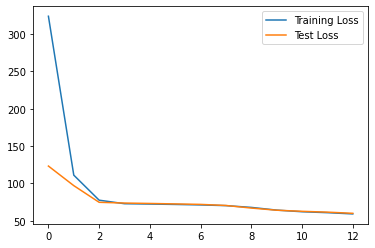

[14,     1] loss: 56.647
[14,     2] loss: 55.777
[14,     3] loss: 54.188
[14,     4] loss: 53.987
[14,     5] loss: 51.884
[14,     6] loss: 53.748
[14,     7] loss: 58.288
[14,     8] loss: 57.050
[14,     9] loss: 61.978
[14,    10] loss: 56.296
[14,    11] loss: 55.248
[14,    12] loss: 54.251
[14,    13] loss: 55.191
[14,    14] loss: 61.223
[14,    15] loss: 52.194
[14,    16] loss: 59.334
[14,    17] loss: 57.497
[14,    18] loss: 58.560
[14,    19] loss: 56.288
[14,    20] loss: 55.250
[14,    21] loss: 54.039
[14,    22] loss: 52.452
[14,    23] loss: 54.907
[14,    24] loss: 58.970
[14,    25] loss: 55.397
[14,    26] loss: 56.082
[14,    27] loss: 55.513
[14,    28] loss: 59.847
[14,    29] loss: 55.714
[14,    30] loss: 62.472
[14,    31] loss: 56.243
[14,    32] loss: 53.840
[14,    33] loss: 53.343
[14,    34] loss: 53.605
[14,    35] loss: 56.257
[14,    36] loss: 55.245
[14,    37] loss: 59.725
[14,    38] loss: 63.293
[14,    39] loss: 59.317
[14,    40] loss: 57.222


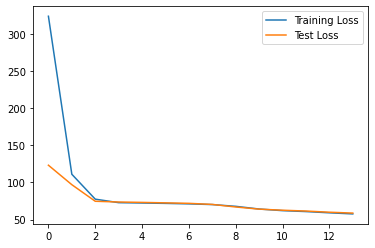

[15,     1] loss: 55.765
[15,     2] loss: 54.060
[15,     3] loss: 53.269
[15,     4] loss: 52.760
[15,     5] loss: 50.652
[15,     6] loss: 52.953
[15,     7] loss: 56.776
[15,     8] loss: 55.670
[15,     9] loss: 59.782
[15,    10] loss: 54.771
[15,    11] loss: 54.119
[15,    12] loss: 52.831
[15,    13] loss: 53.598
[15,    14] loss: 59.507
[15,    15] loss: 51.123
[15,    16] loss: 56.495
[15,    17] loss: 56.027
[15,    18] loss: 56.969
[15,    19] loss: 54.799
[15,    20] loss: 53.594
[15,    21] loss: 52.761
[15,    22] loss: 51.021
[15,    23] loss: 54.101
[15,    24] loss: 58.242
[15,    25] loss: 54.247
[15,    26] loss: 54.855
[15,    27] loss: 54.052
[15,    28] loss: 58.240
[15,    29] loss: 54.319
[15,    30] loss: 60.408
[15,    31] loss: 54.719
[15,    32] loss: 52.441
[15,    33] loss: 52.065
[15,    34] loss: 52.312
[15,    35] loss: 54.930
[15,    36] loss: 53.628
[15,    37] loss: 58.045
[15,    38] loss: 61.320
[15,    39] loss: 58.054
[15,    40] loss: 55.847


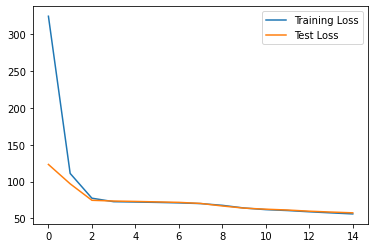

[16,     1] loss: 54.908
[16,     2] loss: 52.841
[16,     3] loss: 52.330
[16,     4] loss: 51.657
[16,     5] loss: 49.615
[16,     6] loss: 52.197
[16,     7] loss: 55.467
[16,     8] loss: 54.685
[16,     9] loss: 58.332
[16,    10] loss: 53.809
[16,    11] loss: 53.147
[16,    12] loss: 52.166
[16,    13] loss: 52.440
[16,    14] loss: 58.371
[16,    15] loss: 50.074
[16,    16] loss: 54.680
[16,    17] loss: 54.931
[16,    18] loss: 55.803
[16,    19] loss: 53.889
[16,    20] loss: 52.329
[16,    21] loss: 51.498
[16,    22] loss: 50.026
[16,    23] loss: 53.015
[16,    24] loss: 57.380
[16,    25] loss: 53.374
[16,    26] loss: 53.345
[16,    27] loss: 53.097
[16,    28] loss: 57.283
[16,    29] loss: 53.383
[16,    30] loss: 59.013
[16,    31] loss: 53.883
[16,    32] loss: 51.845
[16,    33] loss: 51.231
[16,    34] loss: 51.561
[16,    35] loss: 54.199
[16,    36] loss: 52.605
[16,    37] loss: 57.302
[16,    38] loss: 59.907
[16,    39] loss: 57.089
[16,    40] loss: 54.766


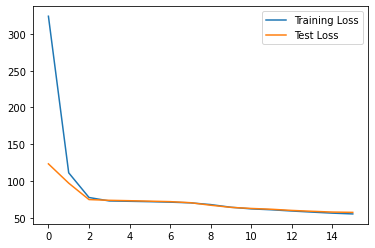

[17,     1] loss: 54.493
[17,     2] loss: 52.035
[17,     3] loss: 51.702
[17,     4] loss: 50.710
[17,     5] loss: 48.950
[17,     6] loss: 51.340
[17,     7] loss: 54.725
[17,     8] loss: 53.829
[17,     9] loss: 57.376
[17,    10] loss: 52.899
[17,    11] loss: 52.527
[17,    12] loss: 51.561
[17,    13] loss: 51.625
[17,    14] loss: 57.286
[17,    15] loss: 49.377
[17,    16] loss: 53.527
[17,    17] loss: 53.889
[17,    18] loss: 54.823
[17,    19] loss: 53.023
[17,    20] loss: 51.475
[17,    21] loss: 50.603
[17,    22] loss: 49.128
[17,    23] loss: 52.221
[17,    24] loss: 56.662
[17,    25] loss: 52.325
[17,    26] loss: 52.053
[17,    27] loss: 52.263
[17,    28] loss: 56.342
[17,    29] loss: 52.474
[17,    30] loss: 57.917
[17,    31] loss: 52.901
[17,    32] loss: 51.047
[17,    33] loss: 50.475
[17,    34] loss: 50.636
[17,    35] loss: 53.316
[17,    36] loss: 51.623
[17,    37] loss: 56.105
[17,    38] loss: 58.754
[17,    39] loss: 55.959
[17,    40] loss: 53.902


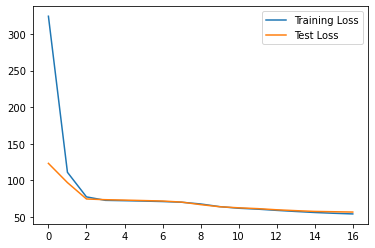

[18,     1] loss: 53.950
[18,     2] loss: 51.233
[18,     3] loss: 50.935
[18,     4] loss: 49.938
[18,     5] loss: 48.251
[18,     6] loss: 50.793
[18,     7] loss: 54.044
[18,     8] loss: 52.873
[18,     9] loss: 56.237
[18,    10] loss: 51.872
[18,    11] loss: 51.790
[18,    12] loss: 50.869
[18,    13] loss: 50.699
[18,    14] loss: 56.126
[18,    15] loss: 48.680
[18,    16] loss: 52.532
[18,    17] loss: 52.778
[18,    18] loss: 53.748
[18,    19] loss: 52.272
[18,    20] loss: 50.637
[18,    21] loss: 49.551
[18,    22] loss: 48.217
[18,    23] loss: 51.374
[18,    24] loss: 55.673
[18,    25] loss: 51.243
[18,    26] loss: 50.821
[18,    27] loss: 51.280
[18,    28] loss: 55.332
[18,    29] loss: 51.512
[18,    30] loss: 56.865
[18,    31] loss: 51.766
[18,    32] loss: 50.204
[18,    33] loss: 49.652
[18,    34] loss: 49.691
[18,    35] loss: 52.390
[18,    36] loss: 50.640
[18,    37] loss: 54.898
[18,    38] loss: 57.598
[18,    39] loss: 54.859
[18,    40] loss: 52.969


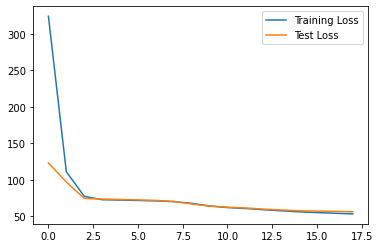

[19,     1] loss: 53.313
[19,     2] loss: 50.302
[19,     3] loss: 50.115
[19,     4] loss: 49.125
[19,     5] loss: 47.507
[19,     6] loss: 50.100
[19,     7] loss: 53.311
[19,     8] loss: 51.863
[19,     9] loss: 55.088
[19,    10] loss: 50.626
[19,    11] loss: 51.080
[19,    12] loss: 49.909
[19,    13] loss: 49.873
[19,    14] loss: 54.799
[19,    15] loss: 47.980
[19,    16] loss: 51.519
[19,    17] loss: 51.737
[19,    18] loss: 52.613
[19,    19] loss: 51.557
[19,    20] loss: 49.732
[19,    21] loss: 48.704
[19,    22] loss: 47.340
[19,    23] loss: 50.499
[19,    24] loss: 54.649
[19,    25] loss: 50.343
[19,    26] loss: 49.613
[19,    27] loss: 50.349
[19,    28] loss: 54.284
[19,    29] loss: 50.698
[19,    30] loss: 55.805
[19,    31] loss: 50.719
[19,    32] loss: 49.331
[19,    33] loss: 48.806
[19,    34] loss: 48.781
[19,    35] loss: 51.455
[19,    36] loss: 49.688
[19,    37] loss: 53.841
[19,    38] loss: 56.361
[19,    39] loss: 53.775
[19,    40] loss: 51.952


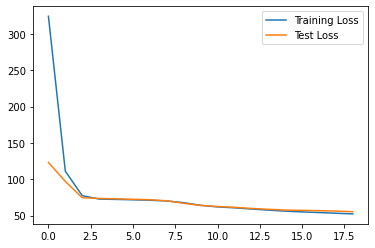

[20,     1] loss: 52.338
[20,     2] loss: 49.365
[20,     3] loss: 49.203
[20,     4] loss: 48.220
[20,     5] loss: 46.710
[20,     6] loss: 49.312
[20,     7] loss: 52.355
[20,     8] loss: 51.050
[20,     9] loss: 53.989
[20,    10] loss: 49.545
[20,    11] loss: 50.304
[20,    12] loss: 48.950
[20,    13] loss: 49.019
[20,    14] loss: 53.584
[20,    15] loss: 47.187
[20,    16] loss: 50.691
[20,    17] loss: 50.607
[20,    18] loss: 51.476
[20,    19] loss: 50.836
[20,    20] loss: 48.856
[20,    21] loss: 47.865
[20,    22] loss: 46.558
[20,    23] loss: 49.616
[20,    24] loss: 53.495
[20,    25] loss: 49.459
[20,    26] loss: 48.711
[20,    27] loss: 49.350
[20,    28] loss: 53.248
[20,    29] loss: 49.883
[20,    30] loss: 54.716
[20,    31] loss: 49.624
[20,    32] loss: 48.420
[20,    33] loss: 47.926
[20,    34] loss: 47.957
[20,    35] loss: 50.374
[20,    36] loss: 48.761
[20,    37] loss: 52.725
[20,    38] loss: 55.108
[20,    39] loss: 52.581
[20,    40] loss: 50.887


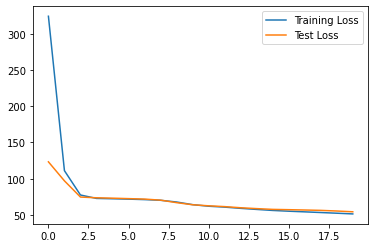

[21,     1] loss: 51.144
[21,     2] loss: 48.412
[21,     3] loss: 48.306
[21,     4] loss: 47.247
[21,     5] loss: 46.016
[21,     6] loss: 48.489
[21,     7] loss: 51.427
[21,     8] loss: 50.039
[21,     9] loss: 53.111
[21,    10] loss: 48.585
[21,    11] loss: 49.520
[21,    12] loss: 48.025
[21,    13] loss: 48.194
[21,    14] loss: 52.419
[21,    15] loss: 46.443
[21,    16] loss: 49.856
[21,    17] loss: 49.443
[21,    18] loss: 50.423
[21,    19] loss: 50.057
[21,    20] loss: 48.111
[21,    21] loss: 47.058
[21,    22] loss: 45.712
[21,    23] loss: 48.871
[21,    24] loss: 52.495
[21,    25] loss: 48.502
[21,    26] loss: 47.922
[21,    27] loss: 48.388
[21,    28] loss: 52.116
[21,    29] loss: 49.079
[21,    30] loss: 53.694
[21,    31] loss: 48.623
[21,    32] loss: 47.507
[21,    33] loss: 47.063
[21,    34] loss: 47.109
[21,    35] loss: 49.447
[21,    36] loss: 47.773
[21,    37] loss: 51.706
[21,    38] loss: 54.102
[21,    39] loss: 51.518
[21,    40] loss: 50.195


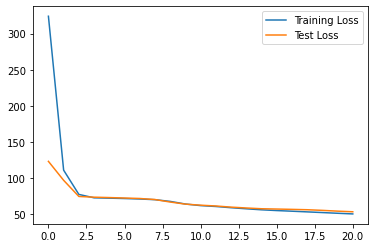

[22,     1] loss: 50.155
[22,     2] loss: 47.795
[22,     3] loss: 47.900
[22,     4] loss: 46.381
[22,     5] loss: 45.760
[22,     6] loss: 47.923
[22,     7] loss: 51.057
[22,     8] loss: 49.093
[22,     9] loss: 52.490
[22,    10] loss: 47.843
[22,    11] loss: 49.058
[22,    12] loss: 47.621
[22,    13] loss: 47.429
[22,    14] loss: 51.889
[22,    15] loss: 45.526
[22,    16] loss: 49.089
[22,    17] loss: 48.416
[22,    18] loss: 50.013
[22,    19] loss: 49.145
[22,    20] loss: 48.108
[22,    21] loss: 46.018
[22,    22] loss: 45.133
[22,    23] loss: 48.665
[22,    24] loss: 51.645
[22,    25] loss: 47.754
[22,    26] loss: 47.955
[22,    27] loss: 47.428
[22,    28] loss: 51.335
[22,    29] loss: 48.456
[22,    30] loss: 52.854
[22,    31] loss: 48.544
[22,    32] loss: 46.888
[22,    33] loss: 46.482
[22,    34] loss: 46.826
[22,    35] loss: 48.764
[22,    36] loss: 47.013
[22,    37] loss: 51.425
[22,    38] loss: 53.110
[22,    39] loss: 50.661
[22,    40] loss: 50.479


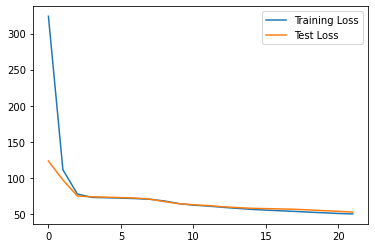

[23,     1] loss: 49.281
[23,     2] loss: 48.060
[23,     3] loss: 45.992
[23,     4] loss: 46.957
[23,     5] loss: 45.176
[23,     6] loss: 47.293
[23,     7] loss: 49.438
[23,     8] loss: 48.668
[23,     9] loss: 51.461
[23,    10] loss: 47.593
[23,    11] loss: 48.060
[23,    12] loss: 47.232
[23,    13] loss: 46.939
[23,    14] loss: 50.736
[23,    15] loss: 45.625
[23,    16] loss: 48.002
[23,    17] loss: 48.371
[23,    18] loss: 48.854
[23,    19] loss: 48.964
[23,    20] loss: 46.885
[23,    21] loss: 45.670
[23,    22] loss: 44.363
[23,    23] loss: 47.611
[23,    24] loss: 50.438
[23,    25] loss: 46.990
[23,    26] loss: 47.055
[23,    27] loss: 46.532
[23,    28] loss: 50.500
[23,    29] loss: 47.737
[23,    30] loss: 52.154
[23,    31] loss: 47.291
[23,    32] loss: 45.928
[23,    33] loss: 45.574
[23,    34] loss: 45.718
[23,    35] loss: 47.993
[23,    36] loss: 46.194
[23,    37] loss: 49.777
[23,    38] loss: 51.727
[23,    39] loss: 49.691
[23,    40] loss: 48.766


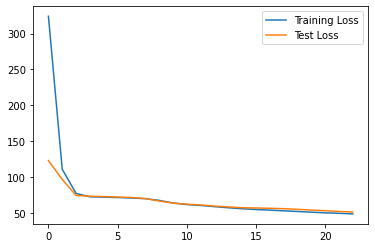

[24,     1] loss: 48.203
[24,     2] loss: 46.764
[24,     3] loss: 45.232
[24,     4] loss: 45.714
[24,     5] loss: 43.756
[24,     6] loss: 46.689
[24,     7] loss: 48.235
[24,     8] loss: 48.020
[24,     9] loss: 50.824
[24,    10] loss: 46.542
[24,    11] loss: 47.351
[24,    12] loss: 46.686
[24,    13] loss: 45.809
[24,    14] loss: 49.872
[24,    15] loss: 44.725
[24,    16] loss: 47.018
[24,    17] loss: 47.688
[24,    18] loss: 47.863
[24,    19] loss: 48.239
[24,    20] loss: 46.254
[24,    21] loss: 44.503
[24,    22] loss: 43.833
[24,    23] loss: 46.763
[24,    24] loss: 49.377
[24,    25] loss: 46.460
[24,    26] loss: 45.977
[24,    27] loss: 45.866
[24,    28] loss: 49.764
[24,    29] loss: 46.856
[24,    30] loss: 51.501
[24,    31] loss: 46.484
[24,    32] loss: 45.224
[24,    33] loss: 45.037
[24,    34] loss: 45.081
[24,    35] loss: 47.480
[24,    36] loss: 45.290
[24,    37] loss: 48.855
[24,    38] loss: 50.691
[24,    39] loss: 48.897
[24,    40] loss: 47.881


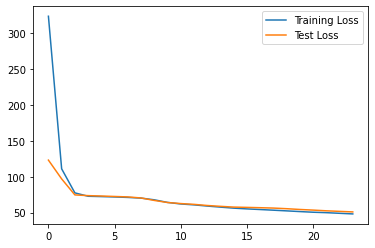

[25,     1] loss: 47.245
[25,     2] loss: 45.858
[25,     3] loss: 44.655
[25,     4] loss: 44.654
[25,     5] loss: 43.065
[25,     6] loss: 45.864
[25,     7] loss: 47.459
[25,     8] loss: 47.076
[25,     9] loss: 49.588
[25,    10] loss: 45.524
[25,    11] loss: 46.586
[25,    12] loss: 45.828
[25,    13] loss: 45.079
[25,    14] loss: 48.705
[25,    15] loss: 43.838
[25,    16] loss: 46.210
[25,    17] loss: 46.761
[25,    18] loss: 47.086
[25,    19] loss: 47.412
[25,    20] loss: 45.641
[25,    21] loss: 43.602
[25,    22] loss: 43.246
[25,    23] loss: 45.918
[25,    24] loss: 48.526
[25,    25] loss: 45.728
[25,    26] loss: 45.162
[25,    27] loss: 45.123
[25,    28] loss: 48.828
[25,    29] loss: 46.082
[25,    30] loss: 50.444
[25,    31] loss: 45.797
[25,    32] loss: 44.528
[25,    33] loss: 44.265
[25,    34] loss: 44.490
[25,    35] loss: 46.783
[25,    36] loss: 44.587
[25,    37] loss: 47.962
[25,    38] loss: 49.721
[25,    39] loss: 48.183
[25,    40] loss: 47.294


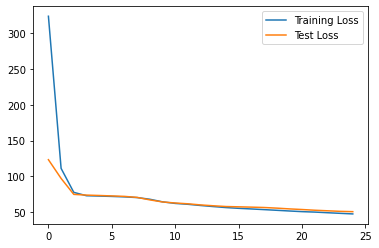

[26,     1] loss: 46.623
[26,     2] loss: 45.184
[26,     3] loss: 44.101
[26,     4] loss: 44.000
[26,     5] loss: 42.476
[26,     6] loss: 45.251
[26,     7] loss: 46.801
[26,     8] loss: 46.280
[26,     9] loss: 48.664
[26,    10] loss: 44.825
[26,    11] loss: 45.800
[26,    12] loss: 45.063
[26,    13] loss: 44.347
[26,    14] loss: 47.655
[26,    15] loss: 42.988
[26,    16] loss: 45.564
[26,    17] loss: 45.792
[26,    18] loss: 46.566
[26,    19] loss: 46.587
[26,    20] loss: 44.925
[26,    21] loss: 42.913
[26,    22] loss: 42.511
[26,    23] loss: 45.247
[26,    24] loss: 47.638
[26,    25] loss: 45.061
[26,    26] loss: 44.295
[26,    27] loss: 44.373
[26,    28] loss: 47.935
[26,    29] loss: 45.292
[26,    30] loss: 49.527
[26,    31] loss: 45.057
[26,    32] loss: 43.878
[26,    33] loss: 43.436
[26,    34] loss: 43.817
[26,    35] loss: 46.062
[26,    36] loss: 43.957
[26,    37] loss: 47.179
[26,    38] loss: 48.871
[26,    39] loss: 47.331
[26,    40] loss: 46.800


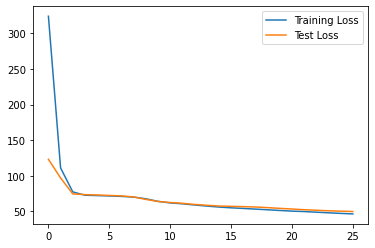

[27,     1] loss: 45.937
[27,     2] loss: 44.667
[27,     3] loss: 43.524
[27,     4] loss: 43.249
[27,     5] loss: 41.951
[27,     6] loss: 44.544
[27,     7] loss: 46.147
[27,     8] loss: 45.439
[27,     9] loss: 47.719
[27,    10] loss: 44.093
[27,    11] loss: 45.202
[27,    12] loss: 44.325
[27,    13] loss: 43.726
[27,    14] loss: 46.805
[27,    15] loss: 42.190
[27,    16] loss: 44.954
[27,    17] loss: 44.916
[27,    18] loss: 45.968
[27,    19] loss: 45.978
[27,    20] loss: 44.169
[27,    21] loss: 42.301
[27,    22] loss: 41.822
[27,    23] loss: 44.477
[27,    24] loss: 46.966
[27,    25] loss: 44.308
[27,    26] loss: 43.586
[27,    27] loss: 43.523
[27,    28] loss: 47.113
[27,    29] loss: 44.668
[27,    30] loss: 48.762
[27,    31] loss: 44.553
[27,    32] loss: 43.182
[27,    33] loss: 42.840
[27,    34] loss: 43.139
[27,    35] loss: 45.394
[27,    36] loss: 43.352
[27,    37] loss: 46.433
[27,    38] loss: 48.055
[27,    39] loss: 46.432
[27,    40] loss: 46.015


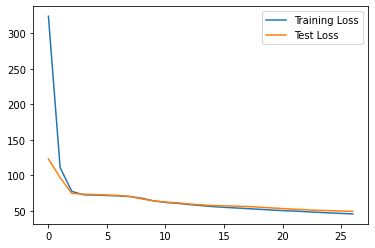

[28,     1] loss: 45.223
[28,     2] loss: 44.060
[28,     3] loss: 43.039
[28,     4] loss: 42.359
[28,     5] loss: 41.314
[28,     6] loss: 43.959
[28,     7] loss: 45.357
[28,     8] loss: 44.667
[28,     9] loss: 46.824
[28,    10] loss: 43.121
[28,    11] loss: 44.619
[28,    12] loss: 43.563
[28,    13] loss: 43.013
[28,    14] loss: 45.937
[28,    15] loss: 41.438
[28,    16] loss: 44.104
[28,    17] loss: 44.168
[28,    18] loss: 45.246
[28,    19] loss: 45.255
[28,    20] loss: 43.430
[28,    21] loss: 41.661
[28,    22] loss: 41.048
[28,    23] loss: 43.857
[28,    24] loss: 46.146
[28,    25] loss: 43.714
[28,    26] loss: 42.830
[28,    27] loss: 42.694
[28,    28] loss: 46.308
[28,    29] loss: 43.882
[28,    30] loss: 48.057
[28,    31] loss: 43.873
[28,    32] loss: 42.491
[28,    33] loss: 42.240
[28,    34] loss: 42.444
[28,    35] loss: 44.715
[28,    36] loss: 42.670
[28,    37] loss: 45.779
[28,    38] loss: 47.374
[28,    39] loss: 45.571
[28,    40] loss: 45.365


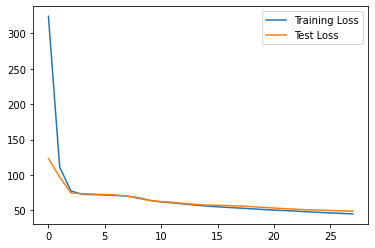

[29,     1] loss: 44.550
[29,     2] loss: 43.396
[29,     3] loss: 42.602
[29,     4] loss: 41.615
[29,     5] loss: 40.694
[29,     6] loss: 43.410
[29,     7] loss: 44.686
[29,     8] loss: 43.914
[29,     9] loss: 45.819
[29,    10] loss: 42.148
[29,    11] loss: 43.909
[29,    12] loss: 42.777
[29,    13] loss: 42.259
[29,    14] loss: 44.971
[29,    15] loss: 40.685
[29,    16] loss: 43.274
[29,    17] loss: 43.425
[29,    18] loss: 44.449
[29,    19] loss: 44.366
[29,    20] loss: 42.753
[29,    21] loss: 40.778
[29,    22] loss: 40.363
[29,    23] loss: 43.097
[29,    24] loss: 45.264
[29,    25] loss: 43.064
[29,    26] loss: 42.010
[29,    27] loss: 42.018
[29,    28] loss: 45.414
[29,    29] loss: 43.168
[29,    30] loss: 47.259
[29,    31] loss: 43.168
[29,    32] loss: 41.788
[29,    33] loss: 41.582
[29,    34] loss: 41.761
[29,    35] loss: 43.975
[29,    36] loss: 41.880
[29,    37] loss: 44.843
[29,    38] loss: 46.528
[29,    39] loss: 44.678
[29,    40] loss: 44.476


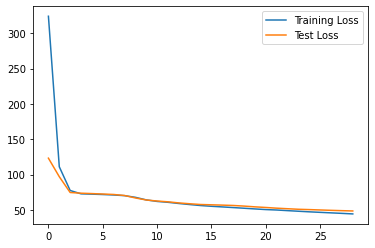

[30,     1] loss: 43.876
[30,     2] loss: 42.545
[30,     3] loss: 41.944
[30,     4] loss: 40.851
[30,     5] loss: 39.890
[30,     6] loss: 42.690
[30,     7] loss: 43.914
[30,     8] loss: 43.006
[30,     9] loss: 44.848
[30,    10] loss: 41.204
[30,    11] loss: 43.191
[30,    12] loss: 41.948
[30,    13] loss: 41.492
[30,    14] loss: 44.036
[30,    15] loss: 40.057
[30,    16] loss: 42.364
[30,    17] loss: 42.853
[30,    18] loss: 43.484
[30,    19] loss: 43.576
[30,    20] loss: 42.045
[30,    21] loss: 39.951
[30,    22] loss: 39.694
[30,    23] loss: 42.496
[30,    24] loss: 44.338
[30,    25] loss: 42.380
[30,    26] loss: 41.154
[30,    27] loss: 41.271
[30,    28] loss: 44.445
[30,    29] loss: 42.383
[30,    30] loss: 46.191
[30,    31] loss: 42.403
[30,    32] loss: 41.065
[30,    33] loss: 40.777
[30,    34] loss: 40.993
[30,    35] loss: 43.154
[30,    36] loss: 41.096
[30,    37] loss: 43.742
[30,    38] loss: 45.468
[30,    39] loss: 43.805
[30,    40] loss: 43.215


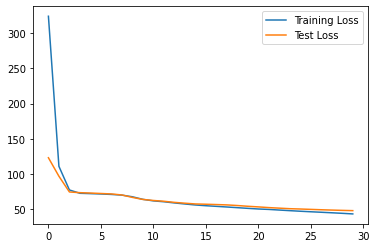

Finished Training


In [29]:
train_loss_graph = []
test_loss_graph = []

for epoch in range(n_epochs):  # loop over the dataset multiple times

    running_loss = 0.0
    total_Loss = 0.0
    correct = 0
    total = 0
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, inputs)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        total_Loss += loss.item()

        if i % print_every == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / print_every))
            running_loss = 0.0
    
    print('LOSS of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    if reduction_loss == "mean":
      total_Loss = total_Loss/i
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    train_loss_graph.append(total_Loss)
    correct = 0
    total = 0
    running_loss = 0.0
    total_Loss = 0.0
    # since we're not training, we don't need to calculate the gradients for our outputs
    with torch.no_grad():
        for j, data in enumerate(testloader,0):
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            # calculate outputs by running images through the network
            outputs = net(inputs)
            loss = criterion(outputs, inputs)
            running_loss += loss.item()
            total_Loss += loss.item()

    print('LOSS of the network on the test images: %d %%' % (total_Loss))
    if reduction_loss == "mean":
      total_Loss = total_Loss/j
      print('Mean of the network on the train images after epoch {} is {}'.format(epoch, total_Loss) )
    
    test_loss_graph.append(total_Loss)
    visualize(train_loss_graph, test_loss_graph)
          

print('Finished Training')

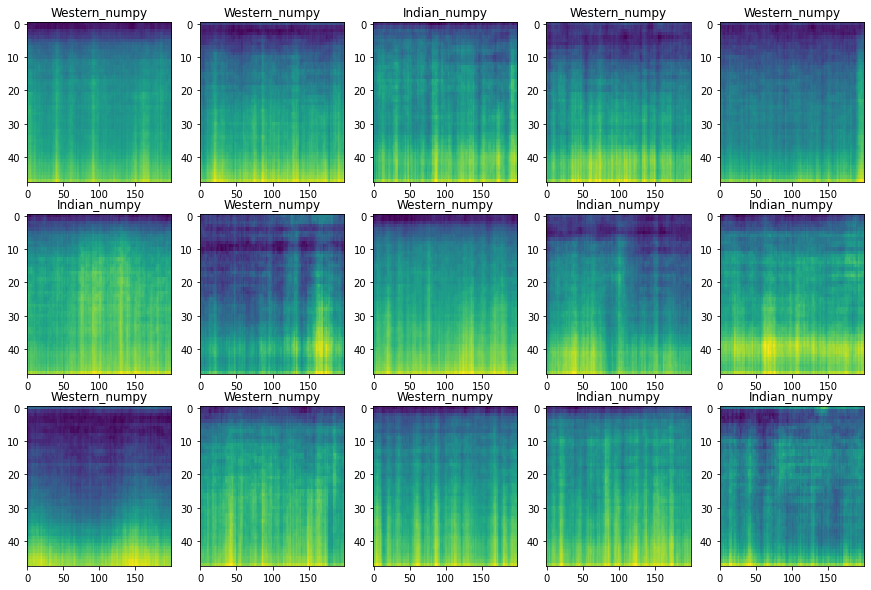

In [30]:
# get some random training images
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(3, 5, figsize=(15, 10))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

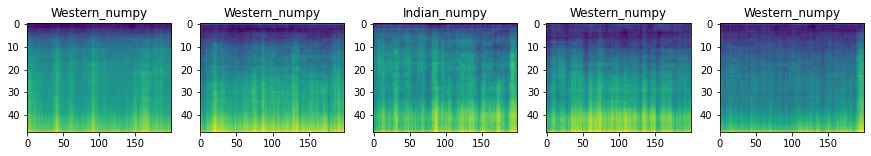

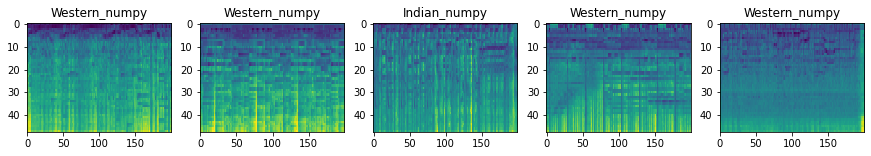

In [31]:
# get some random training images
outputs=[]
dataiter = iter(testloader)
images, labels = dataiter.next()
arthopod_types = {0: 'Indian_numpy', 1: 'Western_numpy', 2: 'country', 3: 'disco', 4: 'hiphop', 5: 'jazz', 6: 'metal', 7: 'pop', 8: 'reggae', 9: 'rock'}
# Viewing data examples used for training
fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for i, ax in enumerate(axis.flat):
    with torch.no_grad():
        image, label = images[i], labels[i]
        image, labels = image.to(device), labels.to(device)
        output_img = net(image.unsqueeze(dim=0))
        ax.imshow(mel_display(output_img.detach().cpu()), interpolation='nearest', aspect='auto') # add image
        outputs.append((mel_display(image.detach().cpu().unsqueeze(dim=0)),arthopod_types[label.item()] ))
        ax.set(title = f"{arthopod_types[label.item()]}") # add label

fig, axis = plt.subplots(1, 5, figsize=(15, 2))
for ax , (image, label) in zip(axis.flat, outputs):
    ax.imshow(image, interpolation='nearest', aspect='auto') # add image
    ax.set(title = f"{label}") # add label
    
        

In [32]:
torch.save(net.state_dict(), os.path.join(BASE_PATH, "final_model.pt"))

Start evaluation - Test model

In [41]:
model = RecurrentAutoencoder(seq_len, input_bins, AE_encoded_dim, device=device)
model.load_state_dict(torch.load(os.path.join(BASE_PATH, "final_model.pt"), map_location=device))

<All keys matched successfully>

Combined data set recinstruction

In [33]:
combined_dataset = MEL_Dataset(dataDF,os.path.join(DATA_BASE_PATH, DATA_IMG_DIR),transform)
combinedloader = torch.utils.data.DataLoader(combined_dataset, batch_size=batch_size)

In [ ]:
# dataDF
# dataDF.loc[1, 'labels']
# classes
# os.path.join(BASE_PATH, "Activations_64", str(classes[label]))

In [ ]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals",  str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id = 0
with torch.no_grad():
    for data in combinedloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        
        for  arr64, arr128, arr48, label in zip(output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", str(classes[label]), str(id) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", classes[label] ,  str(id) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", classes[label] ,  str(id) + ".npy"), np.transpose(arr48, (1,0)))
          id = id + 1

Strict data separation

In [43]:
for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "test", str(class_))
  #print("removing ", dir)
  for f in os.listdir(dir):
    #print("removing ", os.path.join(dir, f))
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "test", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))


for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_64", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "Activations_128", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "reconstructions", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

for class_ in classes:
  dir = os.path.join(BASE_PATH, "originals", "training", str(class_))
  for f in os.listdir(dir):
    os.remove(os.path.join(dir, f))

In [ ]:
id_test = 0
with torch.no_grad():
    for data_test in testloader:
        inputs, labels = data_test
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label in zip(inputs, output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", "test", str(classes[label]), str(id_test) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", "test",str(classes[label]), str(id_test) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "test",classes[label] ,  str(id_test) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "test",classes[label] ,  str(id_test) + ".npy"), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "test",classes[label] ,  str(id_test) + ".npy"), np.transpose(orr48, (1,0)))
          id_test = id_test + 1




In [ ]:
id_train = 0
with torch.no_grad():
    for data in trainloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        output_l2, output_l1 = model.encoder(inputs)
        output = model(inputs)
        output_l2 = output_l2.detach().cpu().numpy()
        output_l1 = output_l1.detach().cpu().numpy()
        output = output.detach().cpu().numpy()
        labels = labels.detach().cpu().numpy()
        inputs = inputs.detach().cpu().numpy()
        
        for  orr48, arr64, arr128, arr48, label in zip(inputs, output_l2, output_l1, output, labels):
          print(os.path.join(BASE_PATH, "Activations_64", "training", str(classes[label]), str(id_train) + ".npy"))
          np.save(os.path.join(BASE_PATH, "Activations_64", "training",str(classes[label]), str(id_train) + ".npy"),np.transpose(arr64, (1,0)))
          np.save(os.path.join(BASE_PATH, "Activations_128", "training",classes[label] ,  str(id_train) + ".npy" ), np.transpose(arr128, (1,0)))
          np.save(os.path.join(BASE_PATH, "reconstructions", "training",classes[label] ,  str(id_train) + ".npy"), np.transpose(arr48, (1,0)))
          np.save(os.path.join(BASE_PATH, "originals", "training",classes[label] ,  str(id_train) + ".npy"), np.transpose(orr48, (1,0)))
          id_train = id_train + 1